# 街景辨識Where am i

## 大綱:
    
    1.定義問題
    
    2.資料探索
    
    3.選擇模型
    
    4.參數調整
    
    5.結果呈現
    
## 1.定義問題:

    我們已經知道這次要辨識15種不同的街景圖，一個經典的分類問題!!okok進入第2步

## 2.資料探索:

    由於我太不知道怎麼使用ImageDataGenerator，或是其他方式可以依照資料夾名稱來讀入data，所以我先土法煉鋼的自己做了csv
    
    雖然笨的但還是可以用啦，我以後還是會好好學習怎麼依照資料夾名稱來讀入data的QQ

In [17]:
#導入要用到的庫
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from glob import glob as gb
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)
from keras.applications.xception import Xception
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

import sys
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k



img_path = gb("./input/train/*.jpg")
label = pd.read_csv("./input/train.csv")

Y_train = label["label"]

y_train = []

for i in label['label']:
    y_train.append([i])
y_train = label['label'].values

y_train.shape

(2985,)

In [18]:
y_train

array([12, 12, 12, ..., 13, 13, 13])

In [19]:
label.head()

,id,label
0,0 (1).jpg,12
1,0 (2).jpg,12
2,0 (3).jpg,12
3,0 (4).jpg,12
4,0 (5).jpg,12


### 2.1數據不平衡

    這邊列出CSV中所有數據比數稍微看一下，發現NO GOOD最少和最多的數據差了將近3倍，這可能讓機器以為label就是一切
    
    但實際訓練可能影響不大，總丟進去才知道結果!!

6     310
8     274
10    260
13    256
4     228
11    215
2     211
3     208
1     192
5     189
14    160
9     141
12    116
7     115
0     110
Name: label, dtype: int64

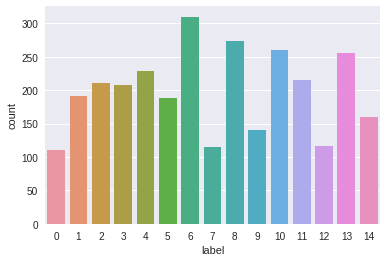

In [20]:
g = sns.countplot(Y_train)

Y_train.value_counts()

### 2.2讀入照片

In [21]:
name = []
for path in label['id'].values:
    img  = cv2.imread('/home/jovyan/comp2/input/train/'+path)
    img2 = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    name.append(imga)
name = np.array(name)

name.shape

(2985, 256, 256, 3)

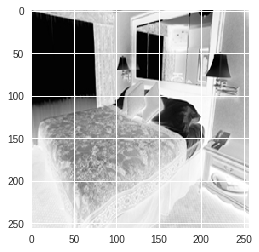

In [22]:
import matplotlib
import matplotlib.pyplot as plt

plt.imshow(name[0][:,:,0])

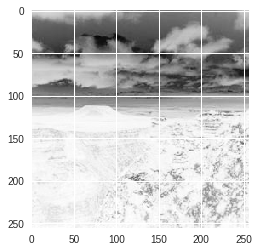

In [23]:
plt.imshow(name[1902][:,:,0])

### 2.3 Normalization

In [24]:
name = name / 255.0  #Normalization

### 2.4 One Hot Encoding

In [25]:
y_train = to_categorical(y_train, num_classes = 15) #one hot

print(y_train[1])

len(y_train)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


2985

### 2.5 切割訓練集驗證集

In [26]:
random_seed = 2 #用random_seed來做作隨機分割

x_train, x_val, y_train, y_val = train_test_split(name, y_train, test_size = 0.1, random_state=random_seed)

## 3.選擇模型

### 3.1模型挑選
 
    這邊我選擇圖像分類赫赫有名的Xception

In [27]:
base_model = Xception(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

    # Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(15, activation='softmax')(x)

    # add your top layer block to your base model
model = Model(base_model.input, predictions)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

### 3.2 keras優化器選擇

<a href="https://keras-cn.readthedocs.io/en/latest/other/optimizers/">關於keras優化器選擇</a>

In [28]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### 3.3 減緩學習速率

    學習速率過快可能導致落入局部最小值，所以我多用ReduceLROnPlateau，當3次val_acc沒有進步時表示training可能落入局部最小值，
    
    所以將速率直接砍半，讓他能繼續往下走。
    
<img src="http://img1.imagilive.com/0717/learningrates.jpg"> </img>

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

### 3.4訓練次數

In [31]:
epochs = 50 
batch_size = 12

### 3.5 數據擴充

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.25,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.25,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(name)

In [33]:
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=name.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 55s - loss: 1.3943 - acc: 0.5502 - val_loss: 1.9073 - val_acc: 0.6120
Epoch 2/50
 - 51s - loss: 0.9439 - acc: 0.6946 - val_loss: 3.0074 - val_acc: 0.5518
Epoch 3/50
 - 52s - loss: 0.7894 - acc: 0.7506 - val_loss: 2.8467 - val_acc: 0.6221
Epoch 4/50
 - 52s - loss: 0.6429 - acc: 0.8118 - val_loss: 2.7325 - val_acc: 0.6288
Epoch 5/50
 - 52s - loss: 0.5745 - acc: 0.8152 - val_loss: 1.0122 - val_acc: 0.8127
Epoch 6/50
 - 52s - loss: 0.5439 - acc: 0.8376 - val_loss: 1.0318 - val_acc: 0.8194
Epoch 7/50
 - 52s - loss: 0.4969 - acc: 0.8458 - val_loss: 1.9264 - val_acc: 0.7057
Epoch 8/50
 - 52s - loss: 0.4348 - acc: 0.8675 - val_loss: 0.6477 - val_acc: 0.8963
Epoch 9/50
 - 52s - loss: 0.4088 - acc: 0.8759 - val_loss: 1.3518 - val_acc: 0.8094
Epoch 10/50
 - 52s - loss: 0.3593 - acc: 0.8925 - val_loss: 1.2653 - val_acc: 0.8127
Epoch 11/50
 - 52s - loss: 0.3549 - acc: 0.8948 - val_loss: 2.3319 - val_acc: 0.7291
Epoch 12/50

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00

In [35]:
model.save("oplast.h5")

## 4 參數調整

    可以看出來在30輪時已經收斂得差不多了不需要設到50。

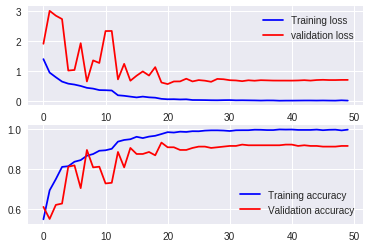

In [36]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.1混淆矩陣

    可以看出label8與6有著較明顯辨識錯誤，其實看過data就大該知道兩者其實真的非常相像
    
    我先透過隨機翻轉和平移來擴充數據來解決兩者容易混淆的問題
    
    但挑整過度又會始label5與12容易出錯(下圖一)
    
    所以最後我取中間值(下圖二)

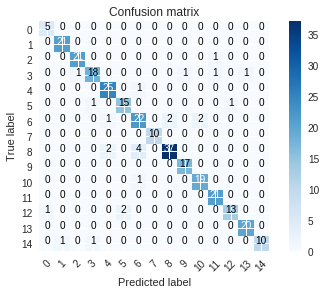

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(15)) 

圖一:
![Image of Yaktocat](./result/amx.PNG)

圖二:
![Image of Yaktocat](./result/2.PNG)

## 5.結果呈現:依照kaggle

In [38]:
label1 = pd.read_csv("./input/test.csv")

print(label1['id'].values[1])

img  = cv2.imread('/home/jovyan/comp2/input/testset/'+label1['id'].values[1]+'.jpg')

print(img)


96baacc2e97886a998807ce197574821a6dc83c227c7469961c01ab315908371
[[[239 239 239]
  [239 239 239]
  [239 239 239]
  ..., 
  [208 208 208]
  [211 211 211]
  [213 213 213]]

 [[238 238 238]
  [238 238 238]
  [239 239 239]
  ..., 
  [210 210 210]
  [211 211 211]
  [212 212 212]]

 [[237 237 237]
  [237 237 237]
  [237 237 237]
  ..., 
  [211 211 211]
  [210 210 210]
  [209 209 209]]

 ..., 
 [[165 165 165]
  [158 158 158]
  [151 151 151]
  ..., 
  [ 92  92  92]
  [ 89  89  89]
  [ 81  81  81]]

 [[153 153 153]
  [151 151 151]
  [149 149 149]
  ..., 
  [101 101 101]
  [ 96  96  96]
  [ 85  85  85]]

 [[140 140 140]
  [152 152 152]
  [163 163 163]
  ..., 
  [104 104 104]
  [ 96  96  96]
  [ 84  84  84]]]


In [39]:
label1 = pd.read_csv("./input/test.csv")



x_test = [] 
for path in label1['id'].values:
    img  = cv2.imread('/home/jovyan/comp2/input/testset/'+path+'.jpg')
    img2 = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
    del img
    imga = np.asarray(img2)
    x_test.append(imga)
x_test = np.array(x_test)

'''test_all = x_test.astype('float32') / 255.0

print(test_all)

print(test_all.shape)

test_prediction = model.predict(test_all)

sampleSubmission = pd.read_csv('./input/test.csv')

submission=pd.DataFrame({"id":range(1,1501),'class':test_prediction})
submission.head()

submission.to_csv("./result5.csv",index=False)'''

x_test = x_test.astype('float32') / 255.0

results = model.predict(x_test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,1501),name = "Id"),results],axis = 1)

submission.to_csv("gg256ss.csv",index=False)

### 排名
![Image of Yaktocat](./result/result.PNG)